In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data, prep_fa_dataset, prep_first_tract_data, prep_fa_flattned_data
from afqinsight.nn.utils import prep_fa_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DAutoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [3]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
from utils import train_variational_autoencoder, train_autoencoder, select_device
from models import Conv1DAutoencoder_fa

In [4]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [5]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [6]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset,batch_size=64)

In [7]:
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    print(f"Training Autoencoder with and Dropout: {dropout}")
    
    # Initialize a new autoencoder for each latent dimension
    test_model = Conv1DAutoencoder_fa(latent_dims=32, dropout=dropout).to(device)
    
    # Train the model 
    training_results = train_autoencoder(model = test_model, train_data=all_tracts_train_loader, val_data=all_tracts_val_loader, epochs = 1, device = device)
    
    # Store both the model and results
    models[dropout] = test_model
    results[dropout] = training_results
    
    print(f"Completed training for dropout={dropout}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")



Training Autoencoder with and Dropout: 0.0
Epoch 1: Saving best model state with RMSE: 0.0143
Epoch 1, Train RMSE: 0.0427, Val RMSE: 0.0143, Recon Loss (Train): 0.5024, Recon Loss (Val): 0.0107
Completed training for dropout=0.0, Best Val RMSE: 0.0143
Training Autoencoder with and Dropout: 0.1
Epoch 1: Saving best model state with RMSE: 0.0238
Epoch 1, Train RMSE: 0.0302, Val RMSE: 0.0238, Recon Loss (Train): 0.0709, Recon Loss (Val): 0.0287
Completed training for dropout=0.1, Best Val RMSE: 0.0238
Training Autoencoder with and Dropout: 0.5
Epoch 1: Saving best model state with RMSE: 0.0244
Epoch 1, Train RMSE: 0.0422, Val RMSE: 0.0244, Recon Loss (Train): 0.1149, Recon Loss (Val): 0.0302
Completed training for dropout=0.5, Best Val RMSE: 0.0244


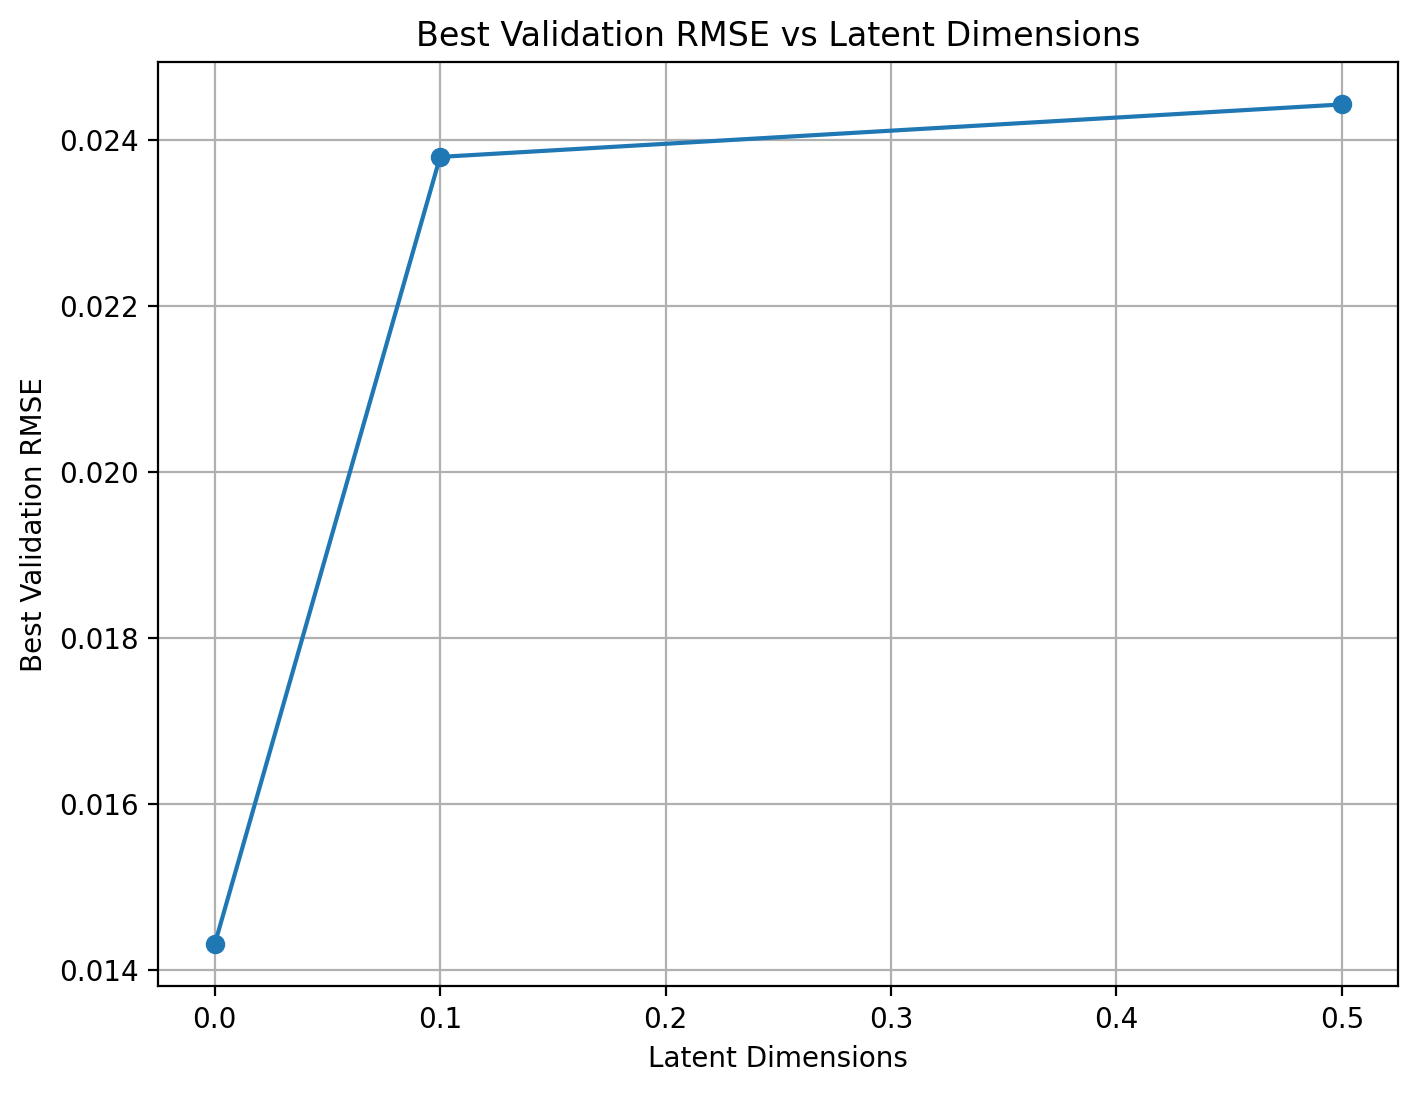

In [13]:
# Extract the latent dimensions and corresponding best validation RMSE values.
dropout_list = sorted(results.keys())
best_val_rmse = [results[dim]["best_val_rmse"] for dim in dropout_list]

plt.figure(figsize=(8, 6))
plt.plot(dropout_list, best_val_rmse, marker='o', linestyle='-')
plt.xlabel("Latent Dimensions")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs Latent Dimensions")
plt.grid(True)
plt.show()


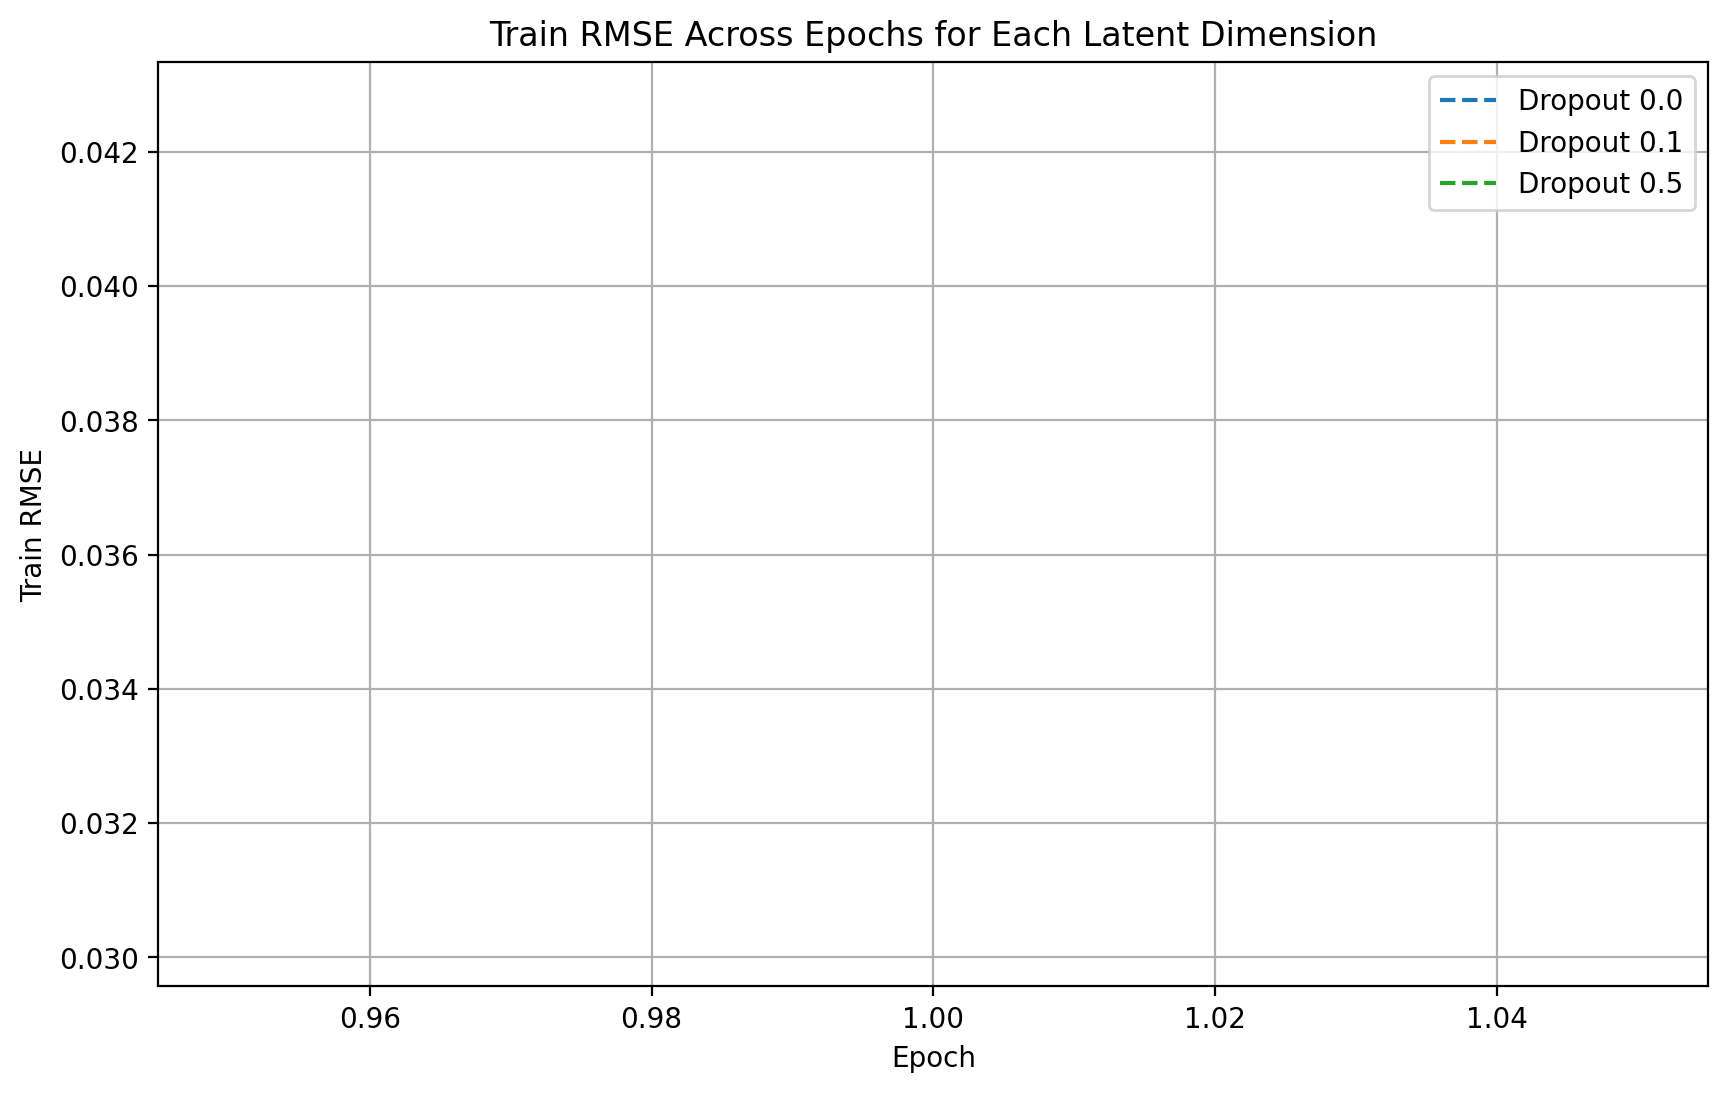

In [14]:
plt.figure(figsize=(10, 6))

# Loop through each latent dimension in your results dictionary
for dropout, training_results in results.items():
    train_rmse = training_results["train_rmse_per_epoch"]
    epochs = range(1, len(train_rmse) + 1)
    plt.plot(epochs, train_rmse, linestyle='--', label=f"Dropout {dropout}")

plt.xlabel("Epoch")
plt.ylabel("Train RMSE")
plt.title("Train RMSE Across Epochs for Each Dropout")
plt.legend()
plt.grid(True)
plt.show()


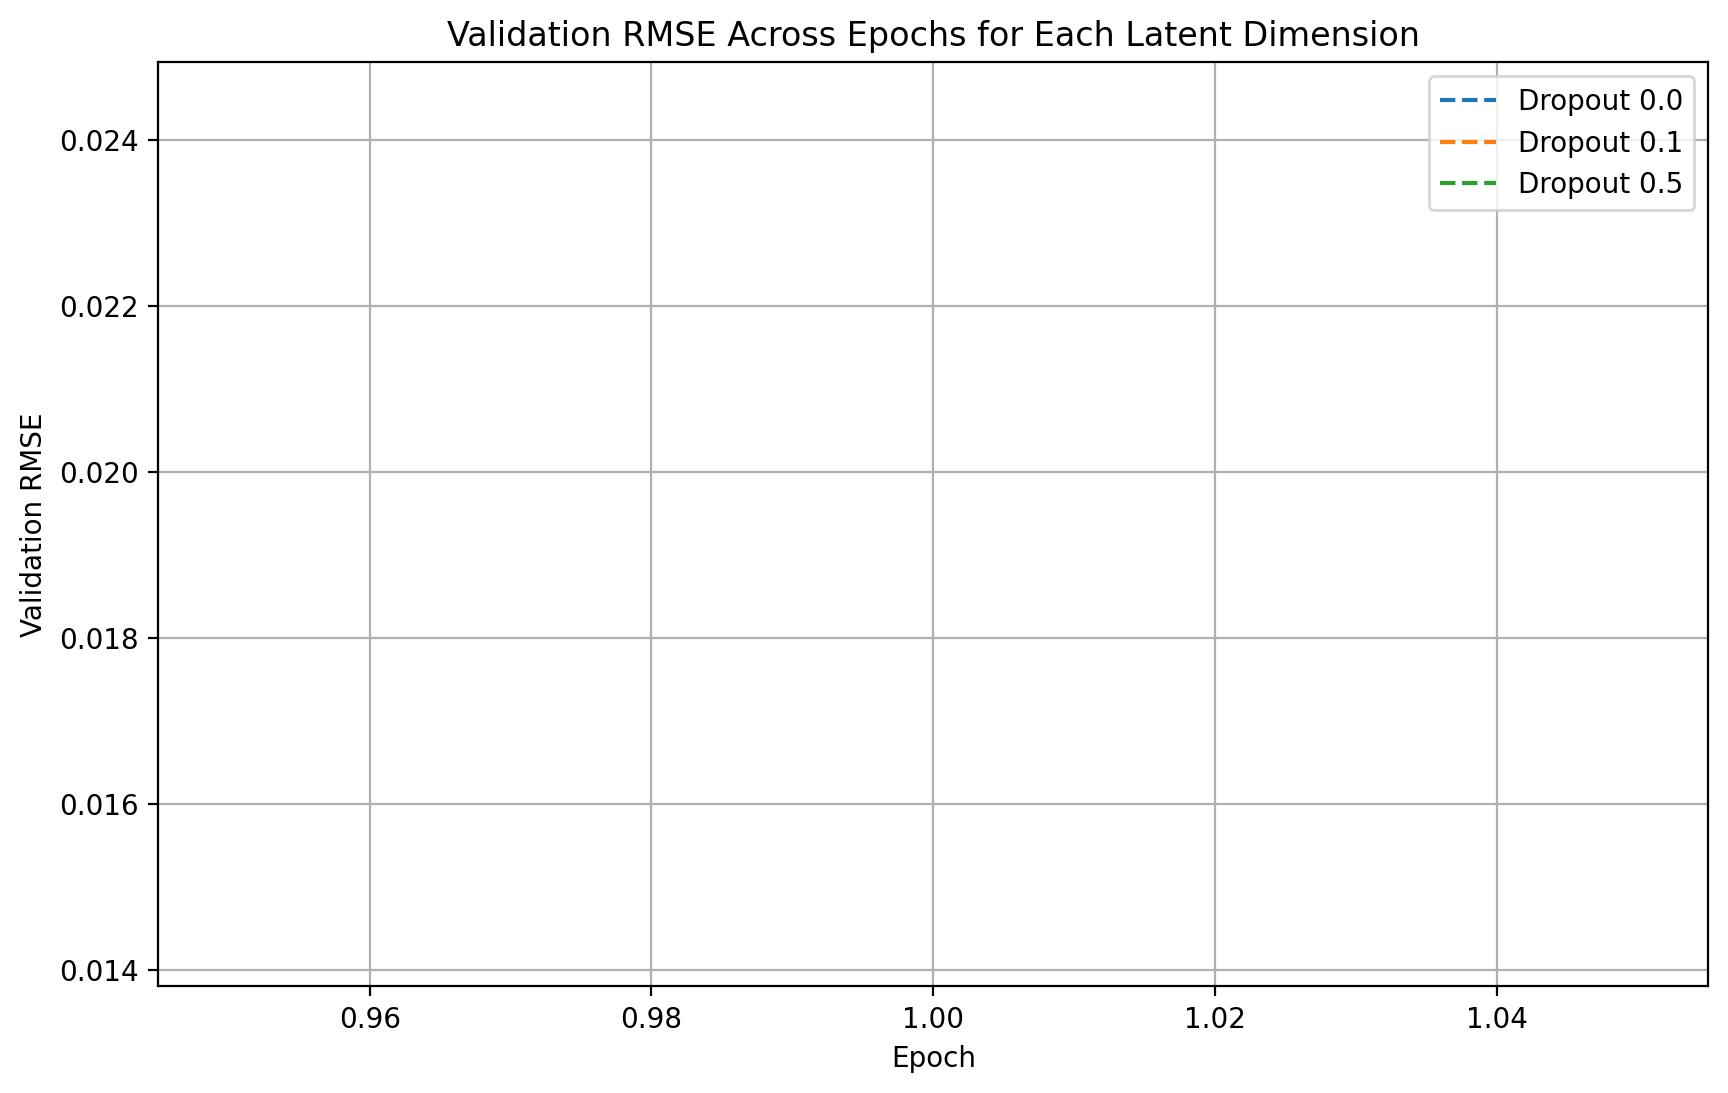

In [16]:
plt.figure(figsize=(10, 6))

# Loop through each latent dimension's results and plot the validation RMSE across epochs.
for dropout, training_results in results.items():
    val_rmse = training_results["val_rmse_per_epoch"]
    epochs = range(1, len(val_rmse) + 1)
    plt.plot(epochs, val_rmse, linestyle='--', label=f"Dropout {dropout}")

plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Across Epochs for Each Dropout")
plt.legend()
plt.grid(True)
plt.show()

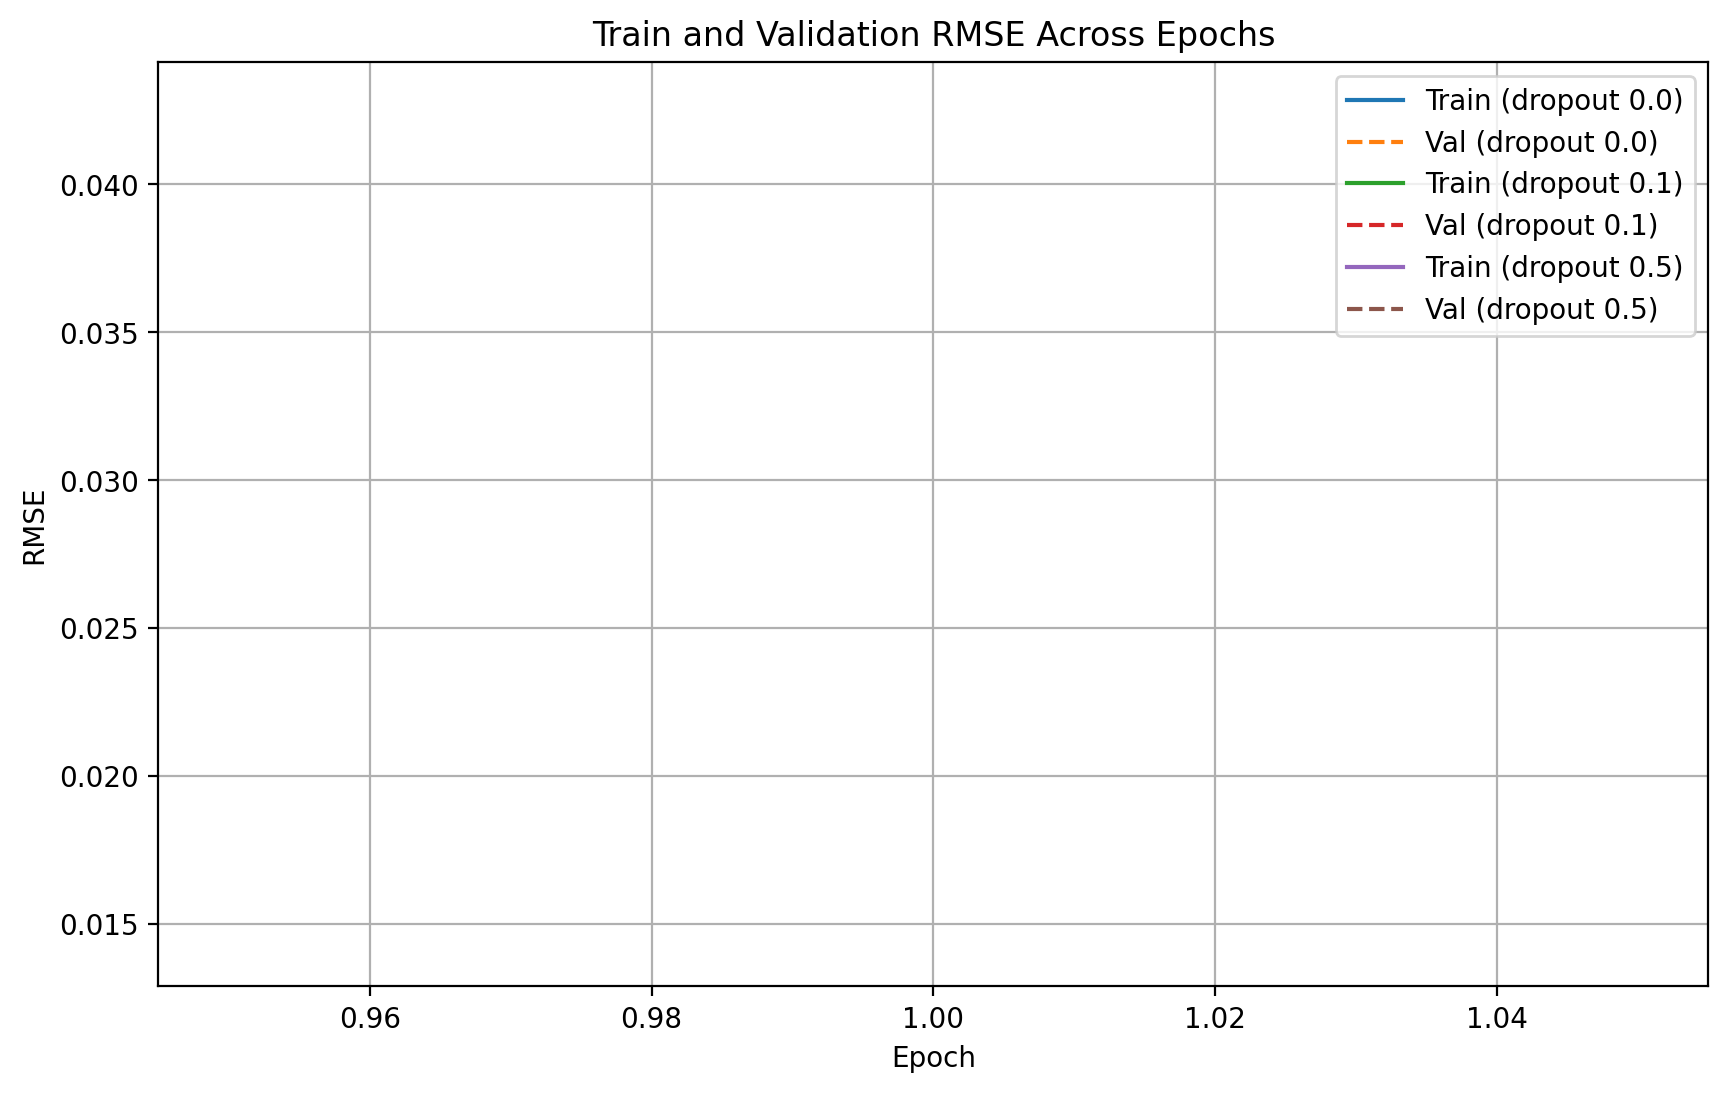

In [17]:
plt.figure(figsize=(10, 6))

# Loop through each latent dimension's results
for dropout, training_results in results.items():
    epochs = range(1, len(training_results["train_rmse_per_epoch"]) + 1)
    train_rmse = training_results["train_rmse_per_epoch"]
    val_rmse = training_results["val_rmse_per_epoch"]
    
    plt.plot(epochs, train_rmse, linestyle='-', label=f"Train (dropout {dropout})")
    plt.plot(epochs, val_rmse,linestyle='--', label=f"Val (dropout {dropout})")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Across Epochs")
plt.legend()
plt.grid(True)
plt.show()

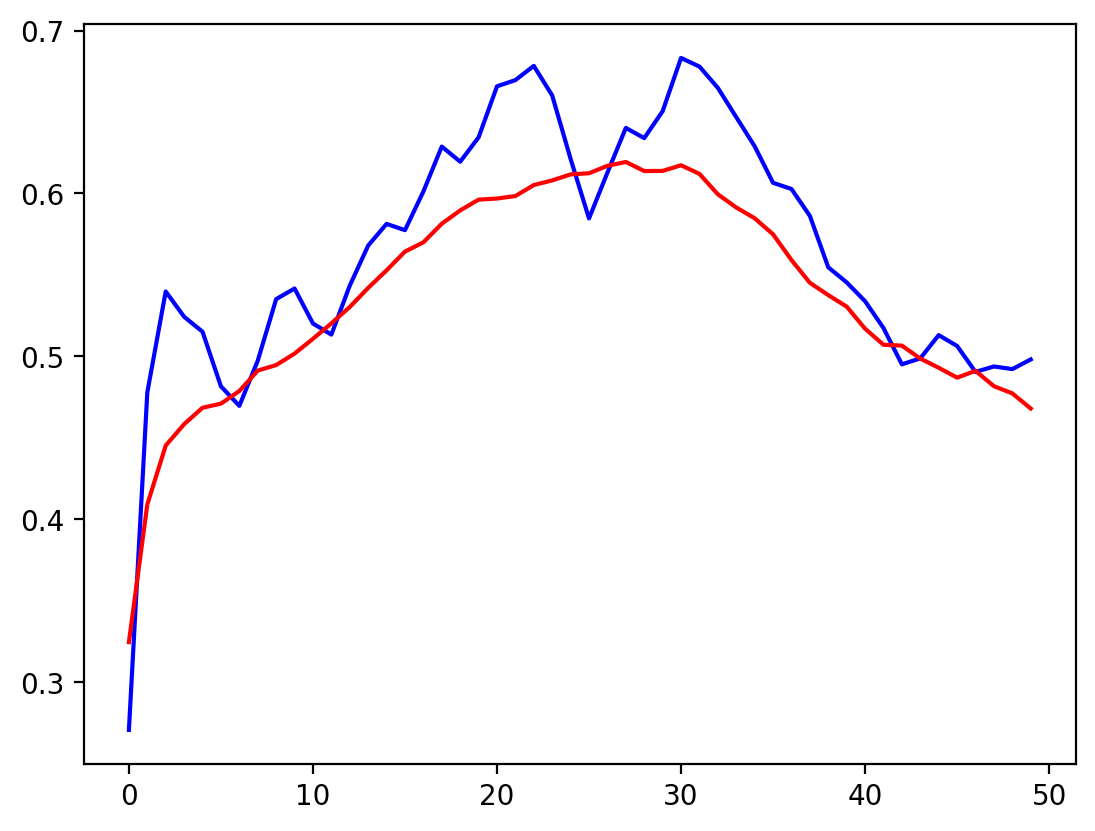

In [19]:
#0.1 dropout
sample = all_tracts_test_loader.dataset[0][0][0:1].unsqueeze(0).to(device)
output = models[0.1](sample)

# Assuming the first element of the tuple is the reconstruction:
reconstructed = output[0]

orig = sample.cpu().detach().numpy()
recon = reconstructed.cpu().detach().numpy()

plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')